## **Parameter Definition**

In [17]:
# import libraries
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.optimize import fsolve
intersection_point = (0, 0)  # default value

# @ parameters for blades
# cutting speed of blade
v_cut_2 = 6 # m2/hr
# life time of blade
a_max_cut_blade = 30 # m^2 for 6-8 m2/hr or 15 m^2 for 3-4 m2/hr
span_blade = a_max_cut_blade/v_cut_2  # = 5hr 
# diameter of blade
d_blade = 0.8 # m (600 mm … 1,600 mm)
# thickness of blade
t_blade = 2.2/1000 # m
# weight of blade
w_blade = np.pi * np.square(d_blade/2) * t_blade * 7800 # kg (steel density 7800 kg/m3)

# @ parameters for materials 
# density of materials
rho_light_reinforced_concrete = 2500
rho_hard_reinforced_concrete = 2770
rho_brick =900
rho_concrete = 2150 # kg/m3 lean concrete

# @ CO2 emission of materials
light_reinforced_concrete_emission = 0.204 # kgCO2eq/kg from KBOB for Switzerland
hard_reinforced_concrete_emission = 0.358 # kgCO2eq/kg from KBOB for Switzerland
brick_emission = 0.267 # kgCO2eq/kg from KBOB for Switzerland
concrete_emission = 0.063 # kgCO2eq/kg from KBOB for Switzerland
steel_CO2_emission = 2.79 # kgCO2eq/kg from KBOB 06.010 Sheet steel, blank, hot rolled, uncoated, thickness 3 mm
# electricity_CO2_emission = 0.01057 # 0.01057285 # kgCO2eq/kWh from KBOB for Switzerland
electricity_CO2_emission = 69.97803127071934 # kgCO2eq/kW from Ecoinvent
diamond_blade_CO2_emission = (334.123*80/35)/span_blade # kgCO2/h # reference: https://ieeexplore.ieee.org/document/10021341

# @ wall saw parameters
# power = 20 # kW, Hilti wall saw DST 20-CA 
power = 32 # kW, Hilti wall saw DST 20-CA (or 40kVA generator using diesel fuel which is around 32kW)

# @ parameters for cutting
fast_cut_speed_area = 6 # m2/hour
slow_cut_speed_area = 3 # m2/hour
cutting_speed = 2-(2-0.7)/(15-5)*(12-5) # 1.08m/min @ 12cm depth

# @ dimensional parameters for a concrete beam
cutting_length = beam_width = 0.4 # meters
cutting_depth = beam_depth = 0.4
beam_length = 4  # meters

# @ transportation parameters
distance_factory_b = 100 # km
# the reuse distance is a times the distance from factory to site
a = 1 
distance_a_storage_b_total = a * distance_factory_b # km
# carbon emission of different transportation methods
lorry_CO2_emission = 0.144 # kgCO2eq/tonkm
truck_CO2_emission = 0.183 # kgCO2eq/tonkm, 16-32 ton truck, assuming 8m|3 of concrete of 32 ton
# load capacity of lorry or concrete truck
size_truck = 9 # m3
weight_concrete_truck = size_truck * rho_concrete # 19.35 ton
lorry_load_capacity = 12e3 # ton
lorry_space_capacity = 9
# Additional information:
# max cutting depth 73 cm
# guide cut at half power consumption at 4cm depth

## **Function Definition**

In [18]:
# calculate the maximum number of concrete beam to be transported for reuse
def max_concrete_beam(v_concrete_beam,rho):
    # cutting_length = v_concrete_beam / (beam_width * beam_depth)
    weight_concrete_beam = v_concrete_beam * rho
    max_num_concrete_beam = np.minimum(np.floor(lorry_space_capacity / v_concrete_beam),np.floor(lorry_load_capacity / weight_concrete_beam))
    return max_num_concrete_beam

# calculate the total weight of concrete beam to be transported for reuse
def total_weight_concrete_beam(v_concrete_beam, rho):
    # v_concrete_beam = cutting_length * beam_width * beam_depth
    weight_concrete_beam = v_concrete_beam * rho
    max_num_concrete_beam = np.minimum(np.floor(lorry_space_capacity / v_concrete_beam),np.floor(lorry_load_capacity / weight_concrete_beam)) #7
    total_weight_concrete_beam = max_num_concrete_beam * weight_concrete_beam
    return total_weight_concrete_beam

# calculate the carbon emission for manufacturing the concrete beam
def manufacturing_cost_beam(carbon_emission, v_concrete_beam, rho):
    weight_concrete_beam = v_concrete_beam * rho
    manufacturing_CO2_cost = carbon_emission * weight_concrete_beam
    return manufacturing_CO2_cost

# calculate the carbon emission for manufacturing the concrete wall
def manufacturing_cost_wall(carbon_emission, wall_volume, rho):
    # wall_volume = wall_thickness * wall_width * wall_height
    manufacturing_CO2_cost = carbon_emission * wall_volume * rho
    return manufacturing_CO2_cost

# calculate the carbon emission for cutting the concrete beam
def cut_impact(electricity_CO2_emission, cutting_time):
    # impact_energy = (power * cutting_time) * (electricity_CO2_emission) # impact of electricity consumption 
    impact_energy = (cutting_time) * (electricity_CO2_emission) # impact of electricity consumption 
    impact_blade = diamond_blade_CO2_emission * cutting_time
    # impact_blade = (w_blade * cutting_time /span_blade) * steel_CO2_emission + (w_diamond * cutting_time /span_blade) * diamond_CO2_emission# impact of blade production
    cut_impact = impact_energy + impact_blade #+ impact_machine
    return cut_impact

# calculate the cutting time for the concrete beam
def cutting_time_beam(cutting_depth, cut_speed_area):
    cutting_pass = np.ceil(cutting_depth/0.12) * 2 # back and forth cut @12cm depth
    cutting_time_speed = 2 * (cutting_length /cutting_speed * cutting_pass + cutting_length/(cutting_speed/2))/60 # hours # two cuts
    cutting_time_area = 2 * ( cutting_length * cutting_depth/ cut_speed_area  + cutting_length/(cutting_speed/2)/60)
    return max(cutting_time_speed, cutting_time_area)

# calculate the cutting time for the concrete wall
def cutting_time_wall(wall_width, wall_height, wall_thickness, cut_speed_area):
    cutting_length = 2*(wall_width+wall_height)
    cutting_depth = wall_thickness
    # number of passes
    cutting_pass = np.ceil(cutting_depth/0.12) * 2 # back and forth cut @12cm depth
    # cutting time depending on speed or area
    cutting_time_speed = (cutting_length /cutting_speed * cutting_pass + cutting_length/(cutting_speed/2))/60 # hours 
    cutting_time_area = ( cutting_length * cutting_depth/ cut_speed_area  + cutting_length/(cutting_speed/2)/60)  
    return max(cutting_time_speed, cutting_time_area)

# calculate the carbon emission for transportation of reused concrete beam
def transport_impact_lorry(total_weight_concrete_beam,distance_a_storage_b_total): # assume fully loaded lorry
    transport_impact_lorry = distance_a_storage_b_total * total_weight_concrete_beam/1000 * lorry_CO2_emission
    return transport_impact_lorry

# calculate the carbon emission for transportation of new concrete
def transport_impact_truck(distance_factory_b, weight_concrete_truck):
    transport_impact_truck = distance_factory_b * weight_concrete_truck/1000 * truck_CO2_emission 
    # transport_impact_truck = concrete_truck_transport * truck_CO2_emission
    return transport_impact_truck

## **Visualizations**

### **Start with only one piece of beam**

In [20]:
# @ plot the carbon emission for transportation of reused concrete beam and new concrete with same transportation distances
import numpy as np
import plotly.graph_objects as go
from scipy.optimize import fsolve

# Define the range of size
v_concrete_beam_range = np.linspace(0.1*beam_depth*beam_width, 10*beam_depth*beam_width, 50)  # Example range for cutting length

# Initialize arrays to store the reuse impact and new impact values
reuse_impact_values = []
new_impact_values = []

# Set constant transportation distances
transportation_distance = 20  # km, assumed constant distance from factory to site
a = 1

for v_concrete_beam in v_concrete_beam_range:
    # Calculate cutting time and other necessary parameters
    cutting_time = cutting_time_beam(cutting_depth, fast_cut_speed_area)
    total_weight_beam = v_concrete_beam * rho_light_reinforced_concrete

    # Calculate reuse impact and new impact
    reuse_impact = cut_impact(electricity_CO2_emission, cutting_time) + transport_impact_lorry(total_weight_beam, a * transportation_distance)
    new_impact = manufacturing_cost_beam(light_reinforced_concrete_emission, v_concrete_beam, rho_light_reinforced_concrete) + transport_impact_truck(transportation_distance, total_weight_beam)

    # Store the impact values
    reuse_impact_values.append(reuse_impact)
    new_impact_values.append(new_impact)

# Find the intersection point with tolerance
tolerance = 1e-5
intersection_func = lambda x: np.interp(x, v_concrete_beam_range, new_impact_values) - np.interp(x, v_concrete_beam_range, reuse_impact_values)
intersection, = fsolve(intersection_func, v_concrete_beam_range[0], xtol=tolerance)

# Print the intersection point
print("Intersection Point: Cutted Volume =", intersection)

# Create a line plot using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=v_concrete_beam_range, y=reuse_impact_values, name='Reuse Impact'))
fig.add_trace(go.Scatter(x=v_concrete_beam_range, y=new_impact_values, name='New Impact'))

# # Add marker for the intersection point
# fig.add_trace(go.Scatter(x=[intersection], y=[np.interp(intersection, v_concrete_beam_range, new_impact_values)],
#                          mode='markers', marker=dict(color='red', size=10), name='Intersection Point'))

# Set plot layout
fig.update_layout(
    xaxis_title='Concrete Beam Volume in m^3',
    yaxis_title='Impact in kg CO2eq',
    title='Environmental Impact vs. Concrete Volume',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)
# fig.update_xaxes(range=[0, 0.5])  # Set x-axis limits

fig.update_layout(template="simple_white")
# Show the plot
fig.show()


Intersection Point: Cutted Volume = 0.05321619988760664


In [27]:
# @ test plot the contribution graph at intersection point
import plotly.express as px

v_concrete_beam = 1.6 #intersection
cutting_time_reuse = cutting_time_beam(cutting_depth, fast_cut_speed_area)

total_weight_beam_reuse = v_concrete_beam * rho_light_reinforced_concrete
total_weight_beam_new = v_concrete_beam * rho_light_reinforced_concrete

reuse_impact_cut = cut_impact(electricity_CO2_emission, cutting_time_reuse)

reuse_transport_impact = transport_impact_lorry(total_weight_beam_reuse, a * transportation_distance)
new_transport_impact = transport_impact_truck(transportation_distance, total_weight_beam_new)

new_manufacturing_impact = manufacturing_cost_beam(light_reinforced_concrete_emission, v_concrete_beam, rho_light_reinforced_concrete)

total_reuse_impact = reuse_impact_cut + reuse_transport_impact
total_new_impact = new_transport_impact + new_manufacturing_impact
print(total_reuse_impact,total_new_impact)

reuse_cut_percentage = (reuse_impact_cut / total_reuse_impact) 
reuse_transport_percentage = (reuse_transport_impact / total_reuse_impact) 
new_transport_percentage = (new_transport_impact / total_new_impact) 
new_manufacturing_percentage = (new_manufacturing_impact / total_new_impact)

import pandas as pd

data = {
    'strategy': ['Reuse', 'New'],
    'Cut Impact': [reuse_cut_percentage, 0],  # For the "New" case, the cut impact is 0
    'Transport Impact': [reuse_transport_percentage, new_transport_percentage],  # For the "New" case, the reuse transport impact is 0
    'Manufacturing Impact': [0, new_manufacturing_percentage]
}

long_df = pd.DataFrame(data)

fig = px.bar(long_df, x="strategy", y=[
    "Cut Impact", "Transport Impact", "Manufacturing Impact"
], title="Impact Breakdown: Reuse vs New Cases", labels={"value": "Contribution Percentage", "strategy": "Case"})
fig.update_layout(barmode="relative", yaxis_tickformat="%")
# Set plot layout
fig.update_layout(
    xaxis_title='Concrete Beam Volume in m^3',
    yaxis_title='Contribution (%)',
    title='Environmental Impact Contribution by Category',
    barmode='stack',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)
fig.update_layout(template="simple_white")

# Show the plot
fig.show()


38.76403353246022 830.64


In [22]:
# @ plot the carbon emission for transportation of reused concrete beam and new concrete with same concrete volumes
import numpy as np
import plotly.graph_objects as go
from scipy.optimize import fsolve

# Define the range of transportation distances
transportation_distance_range = np.linspace(10, 300, 100)

# Define the range of 'a' values
a_values = [1,3,5]

# Initialize dictionaries to store impact values for each 'a' value
reuse_impact_dict = {a: [] for a in a_values}
new_impact_dict = {a: [] for a in a_values}

# Loop through all 'a' values and calculate impact values
for a in a_values:
    for transportation_distance in transportation_distance_range:
        # Calculate reuse impact and new impact based on transportation distance
        cutting_time = cutting_time_beam(cutting_depth, fast_cut_speed_area)
        max_num_concrete_beam = 1 #max_concrete_beam(v_concrete_beam, rho_light_reinforced_concrete)
        # total_weight_beam = total_weight_concrete_beam(v_concrete_beam, rho_light_reinforced_concrete)
        total_weight_beam = v_concrete_beam * rho_light_reinforced_concrete

        # Calculate reuse impact and new impact
        reuse_impact =  cut_impact(electricity_CO2_emission, cutting_time) * max_num_concrete_beam \
            + transport_impact_lorry(total_weight_beam, a * transportation_distance) 
        new_impact = manufacturing_cost_beam(light_reinforced_concrete_emission, v_concrete_beam, rho_light_reinforced_concrete) * max_num_concrete_beam \
            + transport_impact_truck(transportation_distance, total_weight_beam) 

        # Store impact values in dictionaries
        reuse_impact_dict[a].append(reuse_impact)
        new_impact_dict[a].append(new_impact)

# Create line plots for reuse impact and new impact vs transportation distance
fig = go.Figure()

for a in a_values:
    fig.add_trace(go.Scatter(x=transportation_distance_range, y=reuse_impact_dict[a], mode='lines', name=f'Reuse Impact (a={a})'))
fig.add_trace(go.Scatter(x=transportation_distance_range, y=new_impact_dict[1], mode='lines', name=f'New Impact'))
# Set plot layout
fig.update_layout(
    xaxis_title='Transportation Distance in km',
    yaxis_title='Impact Value kg/CO^2',
    title='Impact vs Transportation Distance for Different "a" Values',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)
fig.update_layout(template="simple_white")

# Show the plot
fig.show()



### **Assuming one wall**

In [37]:
v_concrete_wall = 5 #intersection
wall_width = v_concrete_wall / (0.6 * 3)
cutting_time_reuse =cutting_time_wall(wall_width, 3, 0.6, fast_cut_speed_area)
a=1
total_weight_wall_reuse = v_concrete_wall * rho_light_reinforced_concrete
total_weight_wall_new = v_concrete_wall * rho_light_reinforced_concrete

reuse_impact_cut = cut_impact(electricity_CO2_emission, cutting_time_reuse)

reuse_transport_impact = transport_impact_lorry(total_weight_wall_reuse, a * transportation_distance)
new_transport_impact = transport_impact_truck(transportation_distance, total_weight_wall_new)

new_manufacturing_impact = manufacturing_cost_wall(light_reinforced_concrete_emission, v_concrete_wall, rho_light_reinforced_concrete)


total_reuse_impact = reuse_impact_cut + reuse_transport_impact
total_new_impact = new_transport_impact + new_manufacturing_impact
print(total_reuse_impact,total_new_impact)

508.22991456264367 2595.75


In [29]:
import numpy as np
import plotly.graph_objects as go
from scipy.optimize import fsolve

# Define the range of size
v_concrete_wall_range = np.linspace(0.1, 15, 50)  # Example range for cutting length
wall_height =3  # Example range for cutting length
wall_thickness = 0.6

# Initialize arrays to store the reuse impact and new impact values
reuse_impact_values = []
new_impact_values = []

# Set constant transportation distances
transportation_distance = 20  # km, assumed constant distance from factory to site
a = 1

for v_concrete_wall in v_concrete_wall_range:
    # Calculate cutting time and other necessary parameters
    wall_width = v_concrete_wall / (wall_thickness * wall_height)

    cutting_time = cutting_time_wall(wall_width, wall_height, wall_thickness, fast_cut_speed_area)
    total_weight_wall = v_concrete_wall * rho_light_reinforced_concrete

    # Calculate reuse impact and new impact
    reuse_impact = cut_impact(electricity_CO2_emission, cutting_time) + transport_impact_lorry(total_weight_wall, a * transportation_distance)
    new_impact = manufacturing_cost_wall(light_reinforced_concrete_emission, v_concrete_wall, rho_light_reinforced_concrete) + transport_impact_truck(transportation_distance, total_weight_wall)

    # Store the impact values
    reuse_impact_values.append(reuse_impact)
    new_impact_values.append(new_impact)


# Create a line plot using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=v_concrete_wall_range, y=reuse_impact_values, name='Reuse Impact'))
fig.add_trace(go.Scatter(x=v_concrete_wall_range, y=new_impact_values, name='New Impact'))


# Set plot layout
fig.update_layout(
    xaxis_title='Concrete Wall Volume in m^3',
    yaxis_title='Impact in kg CO2eq',
    title='Environmental Impact vs. Concrete Volume',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)
# fig.update_xaxes(range=[0, 0.5])  # Set x-axis limits
# fig.update_yaxes(range=[0, 3000])  # Set y-axis limits

fig.update_layout(template="simple_white")
# Show the plot
fig.show()


In [18]:
# @test plot contribution graph at intersection point

import plotly.express as px
v_concrete_wall = 5 #intersection
wall_height =3  # Example range for cutting length
wall_thickness = 0.6
wall_width = v_concrete_wall / (wall_thickness * wall_height)

cutting_time_reuse = cutting_time_wall(wall_width, wall_height, wall_thickness, fast_cut_speed_area)
total_weight_wall = v_concrete_wall * rho_light_reinforced_concrete

# Calculate reuse impact and new impact
reuse_impact_cut = cut_impact(electricity_CO2_emission, cutting_time_reuse) 
reuse_transport_impact = transport_impact_lorry(total_weight_wall, a * transportation_distance)
new_manufacturing_impact = manufacturing_cost_wall(light_reinforced_concrete_emission, v_concrete_wall, rho_light_reinforced_concrete) 
new_transport_impact = transport_impact_truck(transportation_distance, total_weight_wall)


total_reuse_impact = reuse_impact_cut + reuse_transport_impact
total_new_impact = new_transport_impact + new_manufacturing_impact
print(reuse_impact_cut, reuse_transport_impact, total_reuse_impact,
    new_transport_impact, new_manufacturing_impact,total_new_impact)

# reuse_cut_percentage = (reuse_impact_cut / total_reuse_impact) 
# reuse_transport_percentage = (reuse_transport_impact / total_reuse_impact) 
# new_transport_percentage = (new_transport_impact / total_new_impact) 
# new_manufacturing_percentage = (new_manufacturing_impact / total_new_impact)

import pandas as pd

data = {
    'strategy': ['Reuse', 'New'],
    'Cut Impact': [reuse_impact_cut, 0],  # For the "New" case, the cut impact is 0
    'Transport Impact': [reuse_transport_impact, new_transport_impact],  # For the "New" case, the reuse transport impact is 0
    'Manufacturing Impact': [0, new_manufacturing_impact]
}

long_df = pd.DataFrame(data)

fig = px.bar(long_df, x="strategy", y=[
    "Cut Impact", "Transport Impact", "Manufacturing Impact"
], title="Impact Breakdown: Reuse vs New Cases", labels={"value": "Contribution Percentage", "strategy": "Case"})
# fig.update_layout(barmode="relative", yaxis_tickformat="%")
# Set plot layout
fig.update_layout(
    xaxis_title='Concrete Wall Volume in m^3',
    yaxis_title='Contribution (%)',
    title='Environmental Impact Contribution by Category',
    barmode='stack',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)
fig.update_layout(template="simple_white")

# Show the plot
fig.show()


57.453578214649774 36.0 93.45357821464978 45.75 2550.0 2595.75


### **Maximal loaded, Assuming Transportation Distances are Constant**

In [38]:
import numpy as np
import plotly.graph_objects as go
from scipy.optimize import fsolve

# Define the range of size
v_concrete_beam_range = np.linspace(0.1*beam_depth*beam_width, 10*beam_depth*beam_width, 100)  # Example range for cutting length

# Initialize arrays to store the reuse impact and new impact values
reuse_impact_values = []
new_impact_values = []

# Set constant transportation distances
transportation_distance = 20 # km, assumed constant distance from factory to site
a=1

for v_concrete_beam in v_concrete_beam_range:
    # Calculate cutting time and other necessary parameters
    cutting_time = cutting_time_beam(cutting_depth, fast_cut_speed_area)
    max_num_concrete_beam = max_concrete_beam(v_concrete_beam,rho_light_reinforced_concrete)
    total_weight_beam = total_weight_concrete_beam(v_concrete_beam, rho_light_reinforced_concrete)

    # Calculate reuse impact and new impact
    reuse_impact =  cut_impact(electricity_CO2_emission, cutting_time) * max_num_concrete_beam \
            + transport_impact_lorry(total_weight_beam, a*transportation_distance) 
    new_impact = manufacturing_cost_beam(light_reinforced_concrete_emission, v_concrete_beam, rho_light_reinforced_concrete) * max_num_concrete_beam \
            + transport_impact_truck(transportation_distance, total_weight_beam) 

    # Store the impact values
    reuse_impact_values.append(reuse_impact)
    new_impact_values.append(new_impact)

# Find the intersection point with tolerance
tolerance = 1e-5
intersection_func = lambda x: np.interp(x, v_concrete_beam_range, new_impact_values) - np.interp(x, v_concrete_beam_range, reuse_impact_values)
intersection, = fsolve(intersection_func, v_concrete_beam_range[0], xtol=tolerance)

# Print the intersection point
print("Intersection Point: Cutted Volume =", intersection)

# Create a line plot using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=v_concrete_beam_range, y=reuse_impact_values, name='Reuse Impact'))
fig.add_trace(go.Scatter(x=v_concrete_beam_range, y=new_impact_values, name='New Impact'))

# # Add marker for the intersection point
# fig.add_trace(go.Scatter(x=[intersection], y=[np.interp(intersection, v_concrete_beam_range, new_impact_values)],
#                          mode='markers', marker=dict(color='red', size=10),  name='Intersection Point'))

# Set plot layout
fig.update_layout(
    xaxis_title='Concrete Beam Volume in m^3',
    yaxis_title='Impact in kg CO2eq',
    title='Environmental Impact vs. Concrete Volume',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)
fig.update_xaxes(range=[0, 0.5])  # Set x-axis limits
fig.update_yaxes(range=[0, 3000])  # Set y-axis limits

fig.update_layout(template="simple_white")
# Show the plot
fig.show()


Intersection Point: Cutted Volume = 0.054273217432133314


### **Assume constant D_new but changing D_reuse (or ratio "a")**

In [39]:
# Exploring the Impact of Reuse Strategy Ratio on Calculated Min. Cutting Length: Analysis of Ratio  
# import libraries
import numpy as np
import plotly.graph_objects as go
from scipy.optimize import fsolve

# Define the range of 'a' values and cutting length
a_range = np.linspace(0.1, 10, 50)
# Define the range of size
v_concrete_beam_range = np.linspace(0.1*beam_depth*beam_width, 10*beam_depth*beam_width, 100)  # Example range for cutting length

# Initialize an array to store the intersection points for each 'a' value
intersection_points = []

# Loop through all 'a' values and calculate the intersection points
for a in a_range:
    # Initialize arrays to store the reuse impact and new impact values for the current 'a'
    reuse_impact_values = []
    new_impact_values = []
    
    for v_concrete_beam in v_concrete_beam_range:
        # Calculate cutting time and other necessary parameters
        cutting_time = cutting_time_beam(cutting_depth, fast_cut_speed_area)
        max_num_concrete_beam = max_concrete_beam(v_concrete_beam,rho_light_reinforced_concrete)
        total_weight_beam = total_weight_concrete_beam(v_concrete_beam, rho_light_reinforced_concrete)

        # Calculate reuse impact and new impact
        reuse_impact =  cut_impact(electricity_CO2_emission, cutting_time) * max_num_concrete_beam \
            + transport_impact_lorry(total_weight_beam, a*transportation_distance) 
        new_impact = manufacturing_cost_beam(light_reinforced_concrete_emission, v_concrete_beam, rho_light_reinforced_concrete) * max_num_concrete_beam \
            + transport_impact_truck(transportation_distance, total_weight_beam) 

        # Store the impact values
        reuse_impact_values.append(reuse_impact)
        new_impact_values.append(new_impact)
    
    # Find the intersection point with tolerance
    tolerance = 1e-5
    intersection_func = lambda x: np.interp(x, v_concrete_beam_range, new_impact_values) - np.interp(x, v_concrete_beam_range, reuse_impact_values)
    intersection, = fsolve(intersection_func, v_concrete_beam_range[0], xtol=tolerance)
    intersection_points.append(intersection)

# Create a line plot using Plotly
fig = go.Figure()

# Add the ratio "a" versus intersection point data to the plot
fig.add_trace(go.Scatter(x=a_range, y=intersection_points, mode='lines', name='Intersection Point'))

# Set plot layout
fig.update_layout(
    xaxis_title='Ratio "a" = D_reuse/D_new',
    yaxis_title='Intersection Point (Concrete Volume) in m^3',
    title='Ratio "a" vs. Intersection Point',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)
fig.update_layout(template="simple_white")
# Show the plot
fig.show()


### **Min. Beam Size vs Transportation Distances, Different Ratio Values**

In [40]:
# Comparative Analysis of Transportation Distance and Intersection Points for Different Reuse Strategies 
import numpy as np
import plotly.graph_objects as go
from scipy.optimize import fsolve

# Define the range of transportation distances and cutting length
transportation_distance_range = np.linspace(10, 300, 100)
# Define the range of size
v_concrete_beam_range = np.linspace(0.5*beam_depth*beam_width, 10*beam_depth*beam_width, 100)  # Example range for cutting length

# Define the range of 'a' values
a_values = [0.5, 1, 3, 5]

# Initialize a dictionary to store the intersection points for each 'a' value
intersection_points_dict = {a: [] for a in a_values}
# Initialize a dictionary to store the intersection points for each 'a' value
intersection_points_dict = {a: [] for a in a_values}

# Loop through all 'a' values and calculate the intersection points
for a in a_values:
    for transportation_distance in transportation_distance_range:
        # Initialize arrays to store the reuse impact and new impact values for the current 'a' and transportation distance
        reuse_impact_values = []
        new_impact_values = []

        for v_concrete_beam in v_concrete_beam_range:
            # Calculate cutting time and other necessary parameters
            cutting_time = cutting_time_beam(cutting_depth, fast_cut_speed_area)
            max_num_concrete_beam = max_concrete_beam(v_concrete_beam, rho_light_reinforced_concrete)
            total_weight_beam = total_weight_concrete_beam(v_concrete_beam, rho_light_reinforced_concrete)

            # Calculate reuse impact and new impact
            reuse_impact =  cut_impact(electricity_CO2_emission, cutting_time) * max_num_concrete_beam \
                + transport_impact_lorry(total_weight_beam, a * transportation_distance) 
            new_impact = manufacturing_cost_beam(light_reinforced_concrete_emission, v_concrete_beam, rho_light_reinforced_concrete) * max_num_concrete_beam \
                + transport_impact_truck(transportation_distance, total_weight_beam) 

            # Store the impact values
            reuse_impact_values.append(reuse_impact)
            new_impact_values.append(new_impact)

        # Find the intersection point with tolerance
        tolerance = 1e-5
        intersection_func = lambda x: np.interp(x, v_concrete_beam_range, new_impact_values) - np.interp(x, v_concrete_beam_range, reuse_impact_values)
        intersection, = fsolve(intersection_func, v_concrete_beam_range[0], xtol=tolerance)
        intersection_points_dict[a].append(intersection)

# Create line plots for different 'a' values using Plotly
fig = go.Figure()

for a in a_values:
    fig.add_trace(go.Scatter(x=transportation_distance_range, y=intersection_points_dict[a], mode='lines', name=f'a={a}'))

# Set plot layout
fig.update_layout(
    xaxis_title='Transportation Distance in km',
    yaxis_title='Intersection Point (Optimal Concrete Beam Volume) in m^3',
    title='Transportation Distance vs. Intersection Point for Different Ratio "a" Values',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)
fig.update_layout(template="simple_white")
# Show the plot
fig.show()


C:\Users\xiongs\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



In [41]:
# @ checking COV for different ratio values

import numpy as np
import plotly.graph_objects as go
from scipy.optimize import fsolve

# Define the range of 'a' values
a_values = [0.5, 1.2, 2, 3, 4, 5]

# Initialize a dictionary to store the final COV for each 'a' value
final_cov_dict = {a: None for a in a_values}

# Loop through all 'a' values and calculate the final COV
for a in a_values:
    # Initialize arrays to store the reuse impact and new impact values for the current 'a'
    reuse_impact_values = []
    new_impact_values = []

    for transportation_distance in transportation_distance_range:
        # Calculate cutting time and other necessary parameters
        cutting_time = cutting_time_beam(cutting_depth, fast_cut_speed_area)
        max_num_concrete_beam = max_concrete_beam(v_concrete_beam, rho_light_reinforced_concrete)
        total_weight_beam = total_weight_concrete_beam(v_concrete_beam, rho_light_reinforced_concrete)

        # Calculate reuse impact and new impact
        reuse_impact =  cut_impact(electricity_CO2_emission, cutting_time) * max_num_concrete_beam \
                    + transport_impact_lorry(total_weight_beam, a * transportation_distance) 
        new_impact = manufacturing_cost_beam(light_reinforced_concrete_emission, v_concrete_beam, rho_light_reinforced_concrete) * max_num_concrete_beam \
                + transport_impact_truck(transportation_distance, total_weight_beam) 
        # Store the impact values
        reuse_impact_values.append(reuse_impact)
        new_impact_values.append(new_impact)
    
    # Calculate final COV after looping through all transportation distances
    final_cov = np.std(reuse_impact_values) / np.mean(reuse_impact_values)
    final_cov_dict[a] = final_cov

# Create a bar plot for final COV values using Plotly
cov_bar_fig = go.Figure()

cov_bar_fig.add_trace(go.Bar(x=list(final_cov_dict.keys()), y=list(final_cov_dict.values())))

# Set plot layout for COV bar plot
cov_bar_fig.update_layout(
    xaxis_title='Ratio "a"',
    yaxis_title='Final Coefficient of Variation (COV)',
    title='Final COV for Different Ratio "a" Values',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)
cov_bar_fig.update_layout(template="simple_white")
# Show the COV bar plot
cov_bar_fig.show()


### **Assuming both Transportation and Min Volume as Variables**

In [33]:
# plot with plotly
import numpy as np
import plotly.graph_objects as go


transport_distance_range = np.linspace(0.1, 200, 100)  # Example range for transport distance
# Define the range of size
v_concrete_beam_range = np.linspace(0.5*beam_depth*beam_width, 10*beam_depth*beam_width, 100)  # Example range for cutting length

# Create 2D grids of cutting length and transport distance
v_concrete_beam_grid, transport_distance_grid = np.meshgrid(v_concrete_beam_range, transport_distance_range)

# Initialize arrays to store the reuse impact and new impact values
reuse_impact_values = np.zeros_like(v_concrete_beam_grid)
new_impact_values = np.zeros_like(v_concrete_beam_grid)
# assuming the transport distance from site A to storage to site B is 2 times the transport distance from factory to site B
a = 1

# Calculate reuse impact and new impact for each combination of cutting length and transport distance
for i in range(len(v_concrete_beam_range)):
    for j in range(len(transport_distance_range)):
        v_concrete_beam = v_concrete_beam_range[i]
        transport_distance = transport_distance_range[j]
        
        # Calculate cutting time and other necessary parameters
        cutting_time = cutting_time_beam(cutting_depth, fast_cut_speed_area)
        max_num_concrete_beam = max_concrete_beam(v_concrete_beam, rho_light_reinforced_concrete)
        total_weight_beam = total_weight_concrete_beam(v_concrete_beam, rho_light_reinforced_concrete)

        # Calculate reuse impact and new impact
        reuse_impact =  cut_impact(electricity_CO2_emission, cutting_time) * max_num_concrete_beam \
                    + transport_impact_lorry(total_weight_beam, a * transportation_distance) 
        new_impact = manufacturing_cost_beam(light_reinforced_concrete_emission, v_concrete_beam, rho_light_reinforced_concrete) * max_num_concrete_beam \
                + transport_impact_truck(transportation_distance, total_weight_beam) 
                
                
        # Store the impact values in the corresponding arrays
        reuse_impact_values[j, i] = reuse_impact
        new_impact_values[j, i] = new_impact

# Create a 3D surface plot using Plotly
fig = go.Figure(data=[
    go.Surface(x=v_concrete_beam_grid, y=transport_distance_grid, z=reuse_impact_values, name='Reuse Impact', colorscale="viridis", showscale=True),
    go.Surface(x=v_concrete_beam_grid, y=transport_distance_grid, z=new_impact_values, name='New Impact', colorscale="reds", showscale=False)
])

# Set plot layout
fig.update_layout(
    scene=dict(
        xaxis_title='Concrete Beam Volume in m^3',
        yaxis_title='Transport Distance in km',
        zaxis_title='Environmental Impact in kg CO2eq',
    ),
    title='Environmental Impact for Reuse Case vs. New Concrete Case',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)

fig.update_layout(template="simple_white")
# Show the plot
fig.show()

In [45]:
# @ plot the 3D surface plot of Enviromental Impact for different ratio values

import numpy as np
import plotly.graph_objects as go

# Define the range of cutting length, transport distance, and "a"
transport_distance_range = np.linspace(1, 200, 200)  # Example range for transport distance
a_range = np.linspace(1, 5, 3)  # Example range for the variable "a"
# Define the range of size
v_concrete_beam_range = np.linspace(0.5*beam_depth*beam_width, 10*beam_depth*beam_width, 100)  # Example range for cutting length

# Create 2D grids of cutting length, transport distance, and "a"
v_concrete_beam_grid, transport_distance_grid, a_grid = np.meshgrid(v_concrete_beam_range, transport_distance_range, a_range)

# Initialize arrays to store the reuse impact and new impact values
reuse_impact_values = np.zeros_like(v_concrete_beam_grid)
new_impact_values = np.zeros_like(v_concrete_beam_grid)

# Calculate reuse impact and new impact for each combination of cutting length, transport distance, and "a"
for i in range(len(v_concrete_beam_range)):
    for j in range(len(transport_distance_range)):
        for k in range(len(a_range)):
            v_concrete_beam = v_concrete_beam_range[i]
            transport_distance = transport_distance_range[j]
            a = a_range[k]
            
            # Calculate cutting time and other necessary parameters
            cutting_time = cutting_time_beam(cutting_depth, fast_cut_speed_area)
            max_num_concrete_beam = max_concrete_beam(v_concrete_beam, rho_light_reinforced_concrete)
            total_weight_beam = total_weight_concrete_beam(v_concrete_beam, rho_light_reinforced_concrete)

            # Calculate reuse impact and new impact
            reuse_impact =  cut_impact(electricity_CO2_emission, cutting_time) * max_num_concrete_beam \
                        + transport_impact_lorry(total_weight_beam, a * transport_distance) 
            new_impact = manufacturing_cost_beam(light_reinforced_concrete_emission, v_concrete_beam, rho_light_reinforced_concrete) * max_num_concrete_beam \
                    + transport_impact_truck(transport_distance, total_weight_beam) 
                
            
            # Store the impact values in the corresponding arrays
            reuse_impact_values[j, i, k] = reuse_impact
            new_impact_values[j, i, k] = new_impact

# Create a 3D surface plot using Plotly for each value of "a"
fig = go.Figure()
for k, a in enumerate(a_range):
    fig.add_trace(go.Surface(x=v_concrete_beam_grid[:, :, k], y=transport_distance_grid[:, :, k], z=reuse_impact_values[:, :, k],\
        name=f'ratio d_reuse/d_new={a}', colorscale="viridis", showscale=False,showlegend=False,opacity= a/np.max(a_range)))
    fig.add_trace(go.Surface(x=v_concrete_beam_grid[:, :, k], y=transport_distance_grid[:, :, k], z=new_impact_values[:, :, k],\
        name=f'ratio d_reuse/d_new ={a}', colorscale="reds", showscale=False,showlegend=False,opacity= a/np.max(a_range)))

# Set plot layout
fig.update_layout(
    scene=dict(
        xaxis_title='Concrete Beam Volume in m^3',
        yaxis_title='Transport Distance in km',
        zaxis_title='Environmental Impact in kg CO2eq',
    ),
    title='Environmental Impact for Reuse Case vs. New Concrete Case',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)

# Add colorbar for both surfaces
fig.update_layout(coloraxis_colorbar=dict(title='Impact'))
fig.update_layout(template="simple_white")
# Show the plot
fig.show()


In [46]:
# @ plot the 3D surface plot of Min. Cutting Lengths for different ratio values
import numpy as np
import plotly.graph_objects as go
from scipy.optimize import fsolve

# Define the range of transportation distances, cutting length, and 'a' values
transportation_distance_range = np.linspace(10, 200, 50)
v_concrete_beam_range = np.linspace(0.5*beam_depth*beam_width, 10*beam_depth*beam_width, 100)
a_values = np.linspace(0.5, 10, 50)

# Initialize a 2D array to store the intersection points for different combinations of 'a' and transportation distance
intersection_points = np.zeros((len(a_values), len(transportation_distance_range)))

# Loop through all 'a' values and calculate the intersection points
for i, a in enumerate(a_values):
    for j, transportation_distance in enumerate(transportation_distance_range):
        # Initialize arrays to store the reuse impact and new impact values for the current 'a' and transportation distance
        reuse_impact_values = []
        new_impact_values = []

        for v_concrete_beam in v_concrete_beam_range:
     
            # Calculate cutting time and other necessary parameters

            cutting_time = cutting_time_beam(cutting_depth, fast_cut_speed_area)
            max_num_concrete_beam = max_concrete_beam(v_concrete_beam, rho_light_reinforced_concrete)
            total_weight_beam = total_weight_concrete_beam(v_concrete_beam, rho_light_reinforced_concrete)

            # Calculate reuse impact and new impact
            reuse_impact =  cut_impact(electricity_CO2_emission, cutting_time) * max_num_concrete_beam \
                        + transport_impact_lorry(total_weight_beam, a * transportation_distance) 
            new_impact = manufacturing_cost_beam(light_reinforced_concrete_emission, v_concrete_beam, rho_light_reinforced_concrete) * max_num_concrete_beam \
                    + transport_impact_truck(transportation_distance, total_weight_beam) 
                    
            # Store the impact values
            reuse_impact_values.append(reuse_impact)
            new_impact_values.append(new_impact)
            
        # Find the intersection point with tolerance
        tolerance = 1e-5
        intersection_func = lambda x: np.interp(x, v_concrete_beam_range, new_impact_values) - np.interp(x, v_concrete_beam_range, reuse_impact_values)
        intersection, = fsolve(intersection_func, v_concrete_beam_range[0], xtol=tolerance)
        intersection_points[i, j] = intersection

# Create a 3D surface plot using Plotly
fig = go.Figure(data=[go.Surface(z=intersection_points, x=a_values, y=transportation_distance_range)])

# Set plot layout
fig.update_layout(
    scene=dict(
        xaxis_title='Ratio of Transportation Distances D_reuse/D_new',
        yaxis_title='Transportation Distance in km',
        zaxis_title='Optimal Solution: Concrete Beam Volume in m^3',
    ),
    title='3D Surface Plot: Optimal Solution vs. Ratio and Transportation Distance',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)
fig.update_layout(template="simple_white")
# Show the plot
fig.show()

C:\Users\xiongs\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

C:\Users\xiongs\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.



## **Scenario Analysis**

In [52]:
import plotly.express as px
# test contribution graph at intersection point
v_concrete_beam = 0.3 #intersection
d_reuse = 300
d_new = 100
cutting_time_reuse = cutting_time_beam(cutting_depth, fast_cut_speed_area)
max_num_concrete_beam = max_concrete_beam(v_concrete_beam,rho_light_reinforced_concrete)
total_weight_beam = total_weight_concrete_beam(v_concrete_beam, rho_light_reinforced_concrete)

reuse_impact_cut = cut_impact(electricity_CO2_emission, cutting_time_reuse)* max_num_concrete_beam
reuse_transport_impact = transport_impact_lorry(total_weight_beam, d_reuse)
new_transport_impact = transport_impact_truck(d_new, total_weight_beam)
new_manufacturing_impact = manufacturing_cost_beam(light_reinforced_concrete_emission, v_concrete_beam, rho_light_reinforced_concrete) * max_num_concrete_beam  

total_reuse_impact = reuse_impact_cut + reuse_transport_impact
total_new_impact = new_transport_impact + new_manufacturing_impact
print(reuse_impact_cut/total_reuse_impact, reuse_transport_impact/total_reuse_impact,
    new_transport_impact/total_new_impact, new_manufacturing_impact/total_new_impact)

import pandas as pd

data = {
    'strategy': ['Reuse', 'New'],
    'Cut Impact': [reuse_impact_cut, 0],  # For the "New" case, the cut impact is 0
    'Transport Impact': [reuse_transport_impact, new_transport_impact],  # For the "New" case, the reuse transport impact is 0
    'Manufacturing Impact': [0, new_manufacturing_impact]
}
long_df = pd.DataFrame(data)

fig = px.bar(long_df, x="strategy", y=[
    "Cut Impact", "Transport Impact", "Manufacturing Impact"
], title="Impact Breakdown: Reuse vs New Cases", labels={"value": "Contribution Percentage", "strategy": "Case"})

# Set plot layout
fig.update_layout(
    xaxis_title='Concrete Beam Volume in m^3',
    yaxis_title='Contribution (%)',
    title='Environmental Impact Contribution by Category',
    barmode='stack',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)
# set a limit for y axis
fig.update_yaxes(range=[0, 2800])  # Set y-axis limits
fig.update_layout(template="simple_white")

# Show the plot
fig.show()


0.45677718153707914 0.5432228184629209 0.08232118758434548 0.9176788124156545


## **Sensitivity Analysis**

In [ ]:
pip install SALib

Defaulting to user installation because normal site-packages is not writeable
     ------------------------------------- 758.0/758.0 kB 23.4 MB/s eta 0:00:00
     ---------------------------------------- 133.3/133.3 kB ? eta 0:00:00
     -------------------------------------- 115.3/115.3 kB 6.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [ ]:
# import libraries
import numpy as np
import math
from SALib.sample import saltelli
from SALib.util import read_param_file

import numpy as np
import math
from scipy.optimize import fsolve
from SALib.sample import sobol
from SALib.analyze import sobol as sobol_analyze
import matplotlib.pyplot as plt

### **Sensitivity Analysis: Exploring the Influence of Transportation Distance, Ratio "a" and cutting lengths on Re-use Environmental Impact Outcomes**

C:\Users\xiong\AppData\Local\Temp\ipykernel_7732\3301982398.py:24: DeprecationWarning:

`salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`



First order indices: [0.00572667 0.03164518 0.9673918 ]
Total order indices: [0.00815704 0.03335228 0.96723258]


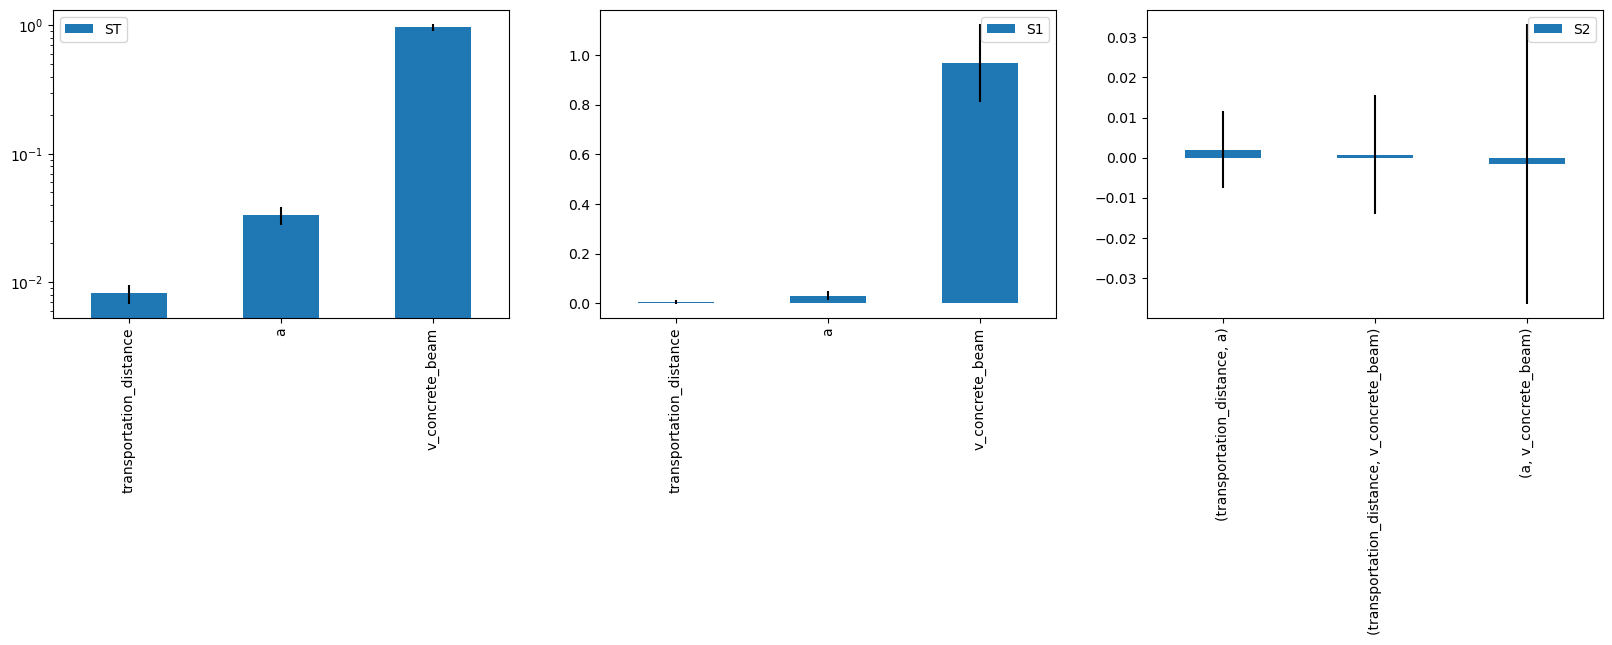

In [ ]:
def calculate(transportation_distance, a, v_concrete_beam):
# Calculate reuse impact and new impact for each cutting length
    # Calculate cutting time and other necessary parameters
    cutting_time = cutting_time_beam(cutting_depth, fast_cut_speed_area)
    max_num_concrete_beam = max_concrete_beam(v_concrete_beam,rho_light_reinforced_concrete)
    total_weight_beam = total_weight_concrete_beam(v_concrete_beam, rho_light_reinforced_concrete)
    
    # Calculate reuse impact and new impact
    reuse_impact =  cut_impact(electricity_CO2_emission, cutting_time) * max_num_concrete_beam \
                + transport_impact_lorry(total_weight_beam, a*transportation_distance) 
    new_impact = manufacturing_cost_beam(light_reinforced_concrete_emission, v_concrete_beam, rho_light_reinforced_concrete) * max_num_concrete_beam \
                + transport_impact_truck(transportation_distance, total_weight_beam) 

    return reuse_impact #new_impact

# Define the ranges for the input parameters
problem = {
    'num_vars': 3,
    'names': ['transportation_distance', 'a', 'v_concrete_beam'],
    'bounds': [[50, 100], [0.5, 3], [0.5*beam_depth*beam_width, 10*beam_depth*beam_width]]
}

# Generate the samples using the Saltelli sampling method
param_values = saltelli.sample(problem, 1024)
# param_values = sobol.sample(problem, 1024)

# Run the model function and calculate the output for each sample
Y = np.zeros([param_values.shape[0]])
for i, X in enumerate(param_values):
    Y[i] = calculate(*X)
# select valid values not NAN
Y = Y[~np.isnan(Y)]
Y = Y[Y != 0]
# Perform the Sobol sensitivity analysis to calculate the sensitivity indices
Si = sobol_analyze.analyze(problem, Y) #, calc_second_order=True, print_to_console=False)

# Print the sensitivity indices
print('First order indices:', Si['S1'])
print('Total order indices:', Si['ST'])

import matplotlib.pyplot as plt
axes = Si.plot()
axes[0].set_yscale('log')
fig = plt.gcf()  # get current figure
fig.set_size_inches(20, 4)

# plt.tight_layout()
plt.show()


### **Sensitivity Analysis: Exploring the Influence of Transportation Distance and Ratio "a" on Minimum Cutting Length Outcomes**

C:\Users\xiong\AppData\Local\Temp\ipykernel_7732\1863302219.py:43: DeprecationWarning:

`salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`

c:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



First order indices: [0.08024789 0.60745153]
Total order indices: [0.30704144 1.20814835]


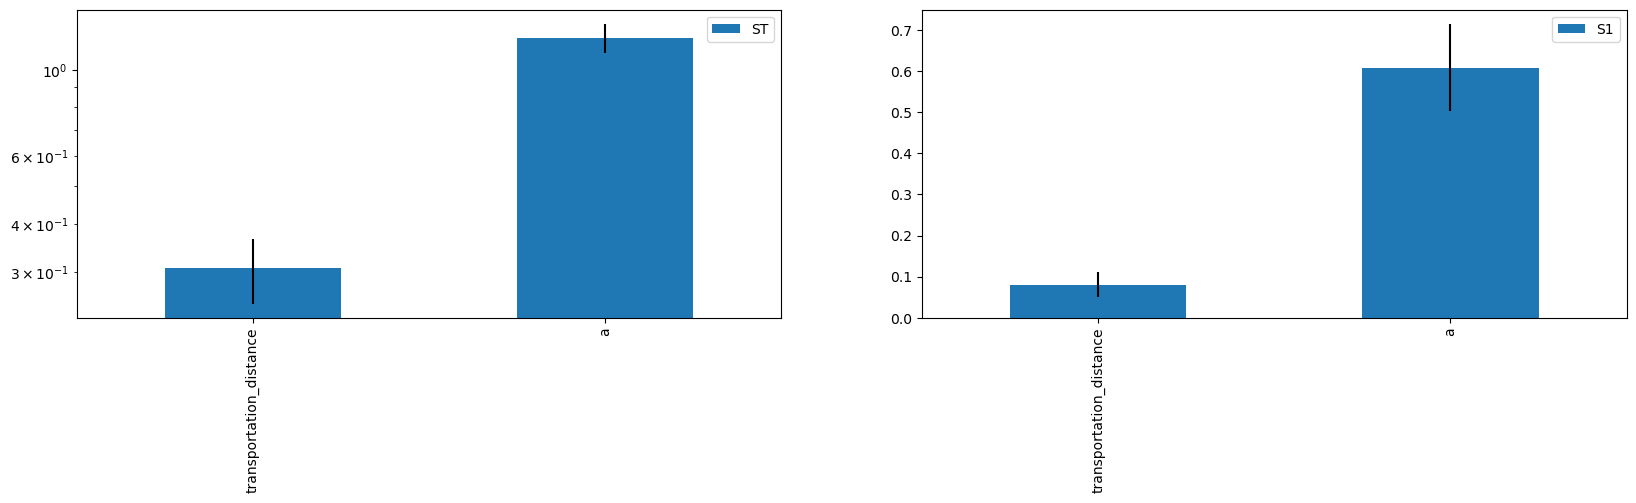

In [ ]:

def calculate(transportation_distance, a):
# Calculate reuse impact and new impact for each cutting length
    # Define the range of cutting length
    v_concrete_beam_range = np.linspace(0.5*beam_depth*beam_width, 10*beam_depth*beam_width, 100)  # Example range for cutting length

    # Initialize arrays to store the reuse impact and new impact values
    reuse_impact_values = []
    new_impact_values = []
    for v_concrete_beam in v_concrete_beam_range:
        # Calculate cutting time and other necessary parameters
        cutting_time = cutting_time_beam(cutting_depth, fast_cut_speed_area)
        max_num_concrete_beam = max_concrete_beam(v_concrete_beam,rho_light_reinforced_concrete)
        total_weight_beam = total_weight_concrete_beam(v_concrete_beam, rho_light_reinforced_concrete)
    
        # Calculate reuse impact and new impact
        reuse_impact =  cut_impact(electricity_CO2_emission, cutting_time) * max_num_concrete_beam \
                + transport_impact_lorry(total_weight_beam, a*transportation_distance) 
        new_impact = manufacturing_cost_beam(light_reinforced_concrete_emission, v_concrete_beam, rho_light_reinforced_concrete) * max_num_concrete_beam \
                + transport_impact_truck(transportation_distance, total_weight_beam) 

        # Store the impact values
        reuse_impact_values.append(reuse_impact)
        new_impact_values.append(new_impact)

    # Find the intersection point with tolerance
    tolerance = 1e-5
    intersection_func = lambda x: np.interp(x, v_concrete_beam_range, new_impact_values) - np.interp(x, v_concrete_beam_range, reuse_impact_values)
    intersection, = fsolve(intersection_func, v_concrete_beam_range[0], xtol=tolerance)
    # return value if exist and valid, otherwise break
    if intersection > 0 and intersection < 10:
        return intersection
    else:
        return 0

# Define the ranges for the input parameters
problem = {
    'num_vars': 2,
    'names': ['transportation_distance', 'a'],
    'bounds': [[10, 300], [0.5, 3]]
}

# Generate the samples using the Saltelli sampling method
param_values = saltelli.sample(problem, 1024)
# param_values = sobol.sample(problem, 1024)

# Run the model function and calculate the output for each sample
Y = np.zeros([param_values.shape[0]])
for i, X in enumerate(param_values):
    Y[i] = calculate(*X)
# select valid values not NAN
Y = Y[~np.isnan(Y)]
Y = Y[Y != 0]
# Perform the Sobol sensitivity analysis to calculate the sensitivity indices
# Si = sobol_analyze.analyze(problem, Y) #, calc_second_order=True, print_to_console=False)
Si = sobol_analyze.analyze(problem, Y, calc_second_order=False)

# Print the sensitivity indices
print('First order indices:', Si['S1'])
print('Total order indices:', Si['ST'])

import matplotlib.pyplot as plt
axes = Si.plot()
axes[0].set_yscale('log')
fig = plt.gcf()  # get current figure
fig.set_size_inches(20, 4)

# plt.tight_layout()
plt.show()
